# Taller 6: Selección de Variables en Modelos Lineales

## Descripción
En este taller exploraremos técnicas para la selección de variables en modelos lineales. Aprenderemos a implementar métodos de selección stepwise desde cero, comprenderemos criterios de información como AIC, BIC y Cp de Mallows, y evaluaremos la estabilidad de los métodos de selección mediante técnicas de remuestreo.

## Objetivos de Aprendizaje
- Implementar métodos de selección stepwise desde cero
- Comprender e implementar criterios de información (AIC, BIC, Cp)
- Evaluar la estabilidad de la selección mediante bootstrap
- Desarrollar un flujo de trabajo sistemático para la selección de variables

## Prerrequisitos
- Conocimiento de regresión lineal múltiple
- Familiaridad con pruebas de hipótesis e intervalos de confianza
- Comprensión del problema de multicolinealidad
- Experiencia básica con técnicas de regularización


In [1]:
# Importación de librerías necesarias

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import itertools
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
sns.set_palette("viridis")


## 1. Fundamentos Teóricos de la Selección de Variables

### 1.1 ¿Por qué seleccionar variables?

En los talleres anteriores, hemos trabajado con modelos lineales donde incluíamos todas las variables predictoras disponibles. Sin embargo, en la práctica, incluir todas las variables no siempre es la mejor estrategia por varias razones:

1. **Parsimonia**: Los modelos más simples son más fáciles de interpretar y comunicar.
2. **Reducción de la varianza**: La inclusión de variables irrelevantes puede aumentar la varianza de las predicciones.
3. **Multicolinealidad**: Como vimos en los talleres 3 y 4, la multicolinealidad puede afectar la estabilidad e interpretación de los coeficientes.
4. **Costo de recolección de datos**: Reducir el número de variables puede disminuir el costo asociado a la recolección de datos.
5. **Generalización**: Los modelos más simples suelen generalizar mejor a nuevos datos.

El objetivo de la selección de variables es encontrar el subconjunto óptimo de predictores que:
- Maximice la capacidad predictiva
- Minimice el error de predicción
- Mantenga la interpretabilidad del modelo
- Evite el sobreajuste

### 1.2 Balance entre sesgo y varianza

La selección de variables está directamente relacionada con el balance entre sesgo y varianza:

- **Modelos con pocas variables**: Tienden a tener alto sesgo y baja varianza.
- **Modelos con muchas variables**: Tienden a tener bajo sesgo pero alta varianza.

El modelo ideal es aquel que encuentra el equilibrio óptimo, minimizando el error total (suma de sesgo al cuadrado y varianza).

$\text{Error total} = \text{Sesgo}^2 + \text{Varianza} + \text{Error irreducible}$

### 1.3 Enfoques para la selección de variables

Existen varios enfoques para la selección de variables:

1. **Métodos basados en pruebas de hipótesis**:
   - Evalúan la significancia estadística de cada variable.
   - Incluyen técnicas como Forward Selection, Backward Elimination y Stepwise Selection.

2. **Métodos basados en criterios de información**:
   - Cuantifican el equilibrio entre bondad de ajuste y complejidad del modelo.
   - Incluyen criterios como AIC, BIC y Cp de Mallows.

3. **Métodos basados en regularización**:
   - Penalizan la magnitud de los coeficientes (como vimos en el Taller 4).
   - Incluyen Lasso, Ridge y Elastic Net.

4. **Métodos basados en la importancia de variables**:
   - Cuantifican la contribución de cada variable al poder predictivo.
   - Incluyen medidas como la importancia de permutación.

En este taller nos centraremos principalmente en los dos primeros enfoques, implementándolos desde cero para entender su funcionamiento interno.


## 2. Criterios de Información

Los criterios de información nos permiten comparar modelos con diferentes números de variables. Estos criterios buscan un equilibrio entre:
- La bondad de ajuste del modelo (medida por la verosimilitud o RSS)
- La complejidad del modelo (medida por el número de parámetros)

### 2.1 Akaike Information Criterion (AIC)

El AIC es uno de los criterios más utilizados y se define como:

$$AIC = -2\ln(L) + 2k$$

Donde:
- $L$ es la máxima verosimilitud del modelo
- $k$ es el número de parámetros (incluyendo el intercepto)

Para modelos lineales con errores normales, el AIC puede expresarse en términos de la suma de residuos al cuadrado (RSS):

$$AIC = n\ln\left(\frac{RSS}{n}\right) + 2k + C$$

Donde $C$ es una constante que no afecta la comparación entre modelos y $n$ es el número de observaciones.

**Interpretación**: Valores más bajos de AIC indican modelos preferibles. El AIC penaliza modelos con muchos parámetros.

### 2.2 Bayesian Information Criterion (BIC)

El BIC es similar al AIC pero penaliza más fuertemente la complejidad del modelo:

$$BIC = -2\ln(L) + k\ln(n)$$

Para modelos lineales con errores normales:

$$BIC = n\ln\left(\frac{RSS}{n}\right) + k\ln(n) + C$$

**Interpretación**: Al igual que con el AIC, valores más bajos de BIC indican modelos preferibles. El BIC penaliza la complejidad del modelo más severamente que el AIC cuando $n > 7$.

### 2.3 Cp de Mallows

El estadístico Cp de Mallows compara directamente la precisión predictiva de un modelo con $p$ parámetros contra el modelo completo:

$$C_p = \frac{RSS_p}{\hat{\sigma}^2} - n + 2p$$

Donde:
- $RSS_p$ es la suma de residuos al cuadrado del modelo con $p$ parámetros
- $\hat{\sigma}^2$ es una estimación de la varianza del error, generalmente obtenida del modelo completo
- $n$ es el número de observaciones
- $p$ es el número de parámetros (incluyendo el intercepto)

**Interpretación**: Se buscan modelos donde $C_p \approx p$. Un valor de $C_p$ significativamente mayor que $p$ sugiere que el modelo tiene sesgo debido a la omisión de variables importantes.

### 2.4 R² Ajustado

El R² ajustado modifica el R² regular para tener en cuenta el número de predictores:

$$R^2_{adj} = 1 - \frac{(1-R^2)(n-1)}{n-p-1}$$

Donde:
- $R^2$ es el coeficiente de determinación regular
- $n$ es el número de observaciones
- $p$ es el número de predictores (sin incluir el intercepto)

**Interpretación**: A diferencia del R² regular, el R² ajustado puede disminuir si se añaden variables que no mejoran sustancialmente el modelo. Se busca maximizar el R² ajustado.

### 2.5 Implementación de criterios de información


In [2]:
# Implementación de criterios de información desde cero

def calcular_aic(y, y_pred, k):
    """
    Calcula el Criterio de Información de Akaike (AIC).

    Parámetros:
    y: array, valores observados
    y_pred: array, valores predichos
    k: int, número de parámetros del modelo (incluyendo intercepto)

    Retorna:
    float: valor de AIC
    """
    n = len(y)
    rss = np.sum((y - y_pred)**2)
    aic = n * np.log(rss/n) + 2*k
    return aic

def calcular_bic(y, y_pred, k):
    """
    Calcula el Criterio de Información Bayesiano (BIC).

    Parámetros:
    y: array, valores observados
    y_pred: array, valores predichos
    k: int, número de parámetros del modelo (incluyendo intercepto)

    Retorna:
    float: valor de BIC
    """
    n = len(y)
    rss = np.sum((y - y_pred)**2)
    bic = n * np.log(rss/n) + k*np.log(n)
    return bic

def calcular_cp_mallows(y, y_pred, k, sigma2=None):
    """
    Calcula el Cp de Mallows.

    Parámetros:
    y: array, valores observados
    y_pred: array, valores predichos
    k: int, número de parámetros del modelo (incluyendo intercepto)
    sigma2: float, estimación de la varianza del error (si None, se calcula del modelo completo)

    Retorna:
    float: valor de Cp de Mallows
    """
    n = len(y)
    rss = np.sum((y - y_pred)**2)

    if sigma2 is None:
        # Utilizamos MSE del modelo completo como estimación de sigma2
        # Esto requiere que se haya ajustado previamente el modelo completo
        raise ValueError("Se requiere una estimación de sigma2")

    cp = rss/sigma2 - n + 2*k
    return cp

def calcular_r2_ajustado(y, y_pred, k):
    """
    Calcula el R2 ajustado.

    Parámetros:
    y: array, valores observados
    y_pred: array, valores predichos
    k: int, número de predictores (sin incluir intercepto)

    Retorna:
    float: valor de R2 ajustado
    """
    n = len(y)
    y_mean = np.mean(y)

    # Suma total de cuadrados
    tss = np.sum((y - y_mean)**2)

    # Suma de residuos al cuadrado
    rss = np.sum((y - y_pred)**2)

    # R2 regular
    r2 = 1 - (rss/tss)

    # R2 ajustado
    r2_adj = 1 - ((1-r2)*(n-1)/(n-k-1))

    return r2_adj

# Función para evaluar todos los criterios de un modelo
def evaluar_modelo(X, y, columnas_seleccionadas, sigma2=None):
    """
    Evalúa un modelo basado en varios criterios de información.

    Parámetros:
    X: DataFrame, predictores completos
    y: array, variable respuesta
    columnas_seleccionadas: list, nombres de las columnas a incluir en el modelo
    sigma2: float, estimación de la varianza del error para Cp de Mallows

    Retorna:
    dict: diccionario con los valores de los criterios
    """
    # Si no hay columnas seleccionadas, devuelve valores por defecto
    if len(columnas_seleccionadas) == 0:
        return {
            'aic': np.inf,
            'bic': np.inf,
            'r2_adj': -np.inf,
            'cp': np.inf if sigma2 else None
        }

    # Seleccionar variables
    X_sel = X[columnas_seleccionadas].copy()

    # Añadir constante
    X_sel = sm.add_constant(X_sel)

    # Ajustar modelo
    modelo = sm.OLS(y, X_sel).fit()

    # Obtener predicciones
    y_pred = modelo.predict(X_sel)

    # Calcular criterios
    k = len(columnas_seleccionadas) + 1  # +1 por el intercepto
    aic = calcular_aic(y, y_pred, k)
    bic = calcular_bic(y, y_pred, k)
    r2_adj = calcular_r2_ajustado(y, y_pred, len(columnas_seleccionadas))

    # Calcular Cp si se proporciona sigma2
    cp = calcular_cp_mallows(y, y_pred, k, sigma2) if sigma2 is not None else None

    resultados = {
        'aic': aic,
        'bic': bic,
        'r2_adj': r2_adj,
        'cp': cp
    }

    return resultados

# Ejemplo de uso
# (Necesitaremos datos para probarlo, que definiremos más adelante)


## 3. Métodos de Selección de Variables Basados en Pruebas

Ahora implementaremos tres métodos clásicos de selección de variables basados en pruebas de hipótesis:

### 3.1 Forward Selection (Selección hacia adelante)

En la selección hacia adelante:
1. Se comienza con un modelo que no incluye ninguna variable predictora (solo intercepto).
2. Para cada variable no incluida en el modelo, se ajusta un modelo que la incluye junto con las variables ya seleccionadas.
3. Se selecciona la variable que produce la mayor mejora según algún criterio (p-valor, AIC, etc.).
4. Se repite el proceso hasta que ninguna variable adicional mejore el modelo o se cumpla algún criterio de parada.

### 3.2 Backward Elimination (Eliminación hacia atrás)

En la eliminación hacia atrás:
1. Se comienza con un modelo que incluye todas las variables predictoras.
2. Se evalúa la contribución de cada variable al modelo.
3. Se elimina la variable menos significativa según algún criterio.
4. Se repite el proceso hasta que todas las variables restantes sean significativas o se cumpla algún criterio de parada.

### 3.3 Stepwise Selection (Selección por pasos)

La selección por pasos es una combinación de los dos métodos anteriores:
1. Generalmente comienza como la selección hacia adelante.
2. Después de añadir una variable, se evalúa si alguna de las variables previamente incluidas debería eliminarse.
3. Este proceso de adición y eliminación continúa hasta que el modelo se estabiliza.

### 3.4 Implementación de algoritmos de selección


In [3]:
# Implementación de algoritmos de selección desde cero

def forward_selection(X, y, criterio='aic', umbral_p=0.05, mostrar_progreso=True):
    """
    Realiza la selección hacia adelante basada en el criterio especificado.

    Parámetros:
    X: DataFrame, predictores
    y: array, variable respuesta
    criterio: str, 'aic', 'bic', 'r2_adj' o 'pvalue'
    umbral_p: float, umbral para considerar una variable significativa
    mostrar_progreso: bool, si se muestra una barra de progreso

    Retorna:
    list: lista de variables seleccionadas
    dict: historial de selección con criterios
    """
    # Lista de todas las columnas disponibles
    todas_columnas = list(X.columns)

    # Inicializamos con ninguna variable seleccionada
    seleccionadas = []
    candidatas = todas_columnas.copy()

    # Para Cp de Mallows, necesitamos sigma2 del modelo completo
    X_completo = sm.add_constant(X)
    modelo_completo = sm.OLS(y, X_completo).fit()
    sigma2 = modelo_completo.mse_resid

    # Diccionario para almacenar la historia de selección
    historial = {'variables': [], 'criterio': [], 'valores': {}}

    # Iteramos hasta que no queden variables para añadir o no mejore el criterio
    iteracion = 0
    mejora = True

    if mostrar_progreso:
        pbar = tqdm(total=len(todas_columnas), desc="Forward Selection")

    while candidatas and mejora:
        iteracion += 1
        mejor_valor = float('inf') if criterio in ['aic', 'bic'] else float('-inf') if criterio in ['r2_adj'] else float('-inf')
        mejor_variable = None
        resultados_mejor = {}

        # Para cada variable candidata, evaluamos el modelo con las ya seleccionadas + esta nueva
        for var in candidatas:
            vars_a_probar = seleccionadas + [var]

            # Si utilizamos p-valor
            if criterio == 'pvalue':
                X_sel = X[vars_a_probar].copy()
                X_sel = sm.add_constant(X_sel)
                modelo = sm.OLS(y, X_sel).fit()
                p_valor = modelo.pvalues[var]  # p-valor de la nueva variable

                if p_valor < umbral_p and p_valor < mejor_valor:
                    mejor_valor = p_valor
                    mejor_variable = var
                    resultados_mejor = {'pvalue': p_valor}
            else:
                # Evaluamos con criterios de información
                resultados = evaluar_modelo(X, y, vars_a_probar, sigma2)

                if (criterio in ['aic', 'bic'] and resultados[criterio] < mejor_valor) or \
                   (criterio == 'r2_adj' and resultados[criterio] > mejor_valor):
                    mejor_valor = resultados[criterio]
                    mejor_variable = var
                    resultados_mejor = resultados

        # Verificamos si hubo mejora
        if mejor_variable is not None:
            # Comparamos con el modelo actual
            if seleccionadas:
                actual_resultados = evaluar_modelo(X, y, seleccionadas, sigma2)

                # Verificamos si hay mejora según el criterio
                if (criterio in ['aic', 'bic'] and mejor_valor >= actual_resultados[criterio]) or \
                   (criterio == 'r2_adj' and mejor_valor <= actual_resultados[criterio]):
                    mejora = False

            # Si hay mejora, añadimos la variable
            if mejora:
                seleccionadas.append(mejor_variable)
                candidatas.remove(mejor_variable)

                # Guardamos en el historial
                historial['variables'].append(seleccionadas.copy())
                historial['criterio'].append(mejor_valor)
                for clave, valor in resultados_mejor.items():
                    historial['valores'].setdefault(clave, []).append(valor)

                if mostrar_progreso:
                    pbar.update(1)
                    pbar.set_description(f"Forward Selection: {len(seleccionadas)} variables, {criterio}={mejor_valor:.4f}")
        else:
            mejora = False

    if mostrar_progreso:
        pbar.close()

    return seleccionadas, historial

def backward_elimination(X, y, criterio='aic', umbral_p=0.05, mostrar_progreso=True):
    """
    Realiza la eliminación hacia atrás basada en el criterio especificado.

    Parámetros:
    X: DataFrame, predictores
    y: array, variable respuesta
    criterio: str, 'aic', 'bic', 'r2_adj' o 'pvalue'
    umbral_p: float, umbral para considerar una variable significativa
    mostrar_progreso: bool, si se muestra una barra de progreso

    Retorna:
    list: lista de variables seleccionadas
    dict: historial de selección con criterios
    """
    # Lista de todas las columnas disponibles
    todas_columnas = list(X.columns)

    # Inicializamos con todas las variables
    seleccionadas = todas_columnas.copy()

    # Para Cp de Mallows, necesitamos sigma2 del modelo completo
    X_completo = sm.add_constant(X)
    modelo_completo = sm.OLS(y, X_completo).fit()
    sigma2 = modelo_completo.mse_resid

    # Evaluamos el modelo inicial
    resultados_inicial = evaluar_modelo(X, y, seleccionadas, sigma2)
    mejor_valor_actual = resultados_inicial[criterio] if criterio in ['aic', 'bic', 'r2_adj'] else None

    # Diccionario para almacenar la historia de selección
    historial = {'variables': [seleccionadas.copy()], 
                'criterio': [mejor_valor_actual if criterio in ['aic', 'bic', 'r2_adj'] else None], 
                'valores': {k: [v] for k, v in resultados_inicial.items()}}

    if mostrar_progreso:
        pbar = tqdm(total=len(todas_columnas), desc="Backward Elimination")

    # Iteramos hasta que no se puedan eliminar más variables
    iteracion = 0
    mejora = True

    while len(seleccionadas) > 0 and mejora:
        iteracion += 1
        mejor_valor = float('inf') if criterio in ['aic', 'bic'] else float('-inf') if criterio in ['r2_adj'] else float('inf')
        peor_variable = None
        resultados_mejor = {}

        # Para cada variable actualmente seleccionada, evaluamos el modelo sin ella
        for var in seleccionadas:
            vars_a_probar = [v for v in seleccionadas if v != var]

            # Si no quedan variables, no podemos evaluar más
            if not vars_a_probar:
                break

            # Si utilizamos p-valor
            if criterio == 'pvalue':
                # Ajustamos el modelo completo para obtener p-valores
                X_sel = X[seleccionadas].copy()
                X_sel = sm.add_constant(X_sel)
                modelo = sm.OLS(y, X_sel).fit()

                # Identificamos la variable menos significativa
                p_valores = modelo.pvalues.drop('const')
                max_p_valor = p_valores.max()
                var_max_p = p_valores.idxmax()

                if max_p_valor > umbral_p and max_p_valor > mejor_valor:
                    mejor_valor = max_p_valor
                    peor_variable = var_max_p
                    resultados_mejor = {'pvalue': max_p_valor}

                # Salimos del bucle ya que ya identificamos la peor variable
                break
            else:
                # Evaluamos con criterios de información
                resultados = evaluar_modelo(X, y, vars_a_probar, sigma2)

                # Para AIC y BIC, buscamos minimizar; para R2 ajustado, maximizar
                if (criterio in ['aic', 'bic'] and resultados[criterio] < mejor_valor) or \
                   (criterio == 'r2_adj' and resultados[criterio] > mejor_valor):
                    mejor_valor = resultados[criterio]
                    peor_variable = var
                    resultados_mejor = resultados

        # Verificamos si eliminar la variable mejora el criterio
        if peor_variable is not None:
            if criterio == 'pvalue':
                if mejor_valor > umbral_p:
                    seleccionadas.remove(peor_variable)

                    # Actualizamos historial
                    resultados = evaluar_modelo(X, y, seleccionadas, sigma2)
                    historial['variables'].append(seleccionadas.copy())
                    historial['criterio'].append(mejor_valor)
                    for clave, valor in resultados.items():
                        historial['valores'].setdefault(clave, []).append(valor)

                    if mostrar_progreso:
                        pbar.update(1)
                        pbar.set_description(f"Backward Elimination: {len(seleccionadas)} variables, max p-value={mejor_valor:.4f}")
                else:
                    mejora = False
            else:
                # Comparamos con el mejor valor actual
                if (criterio in ['aic', 'bic'] and mejor_valor < mejor_valor_actual) or \
                   (criterio == 'r2_adj' and mejor_valor > mejor_valor_actual):
                    seleccionadas.remove(peor_variable)
                    mejor_valor_actual = mejor_valor

                    # Actualizamos historial
                    historial['variables'].append(seleccionadas.copy())
                    historial['criterio'].append(mejor_valor)
                    for clave, valor in resultados_mejor.items():
                        historial['valores'].setdefault(clave, []).append(valor)

                    if mostrar_progreso:
                        pbar.update(1)
                        pbar.set_description(f"Backward Elimination: {len(seleccionadas)} variables, {criterio}={mejor_valor:.4f}")
                else:
                    mejora = False
        else:
            mejora = False

    if mostrar_progreso:
        pbar.close()

    return seleccionadas, historial

def stepwise_selection(X, y, criterio='aic', umbral_p_entrada=0.05, umbral_p_salida=0.10, mostrar_progreso=True):
    """
    Realiza la selección stepwise basada en el criterio especificado.

    Parámetros:
    X: DataFrame, predictores
    y: array, variable respuesta
    criterio: str, 'aic', 'bic', 'r2_adj' o 'pvalue'
    umbral_p_entrada: float, umbral para considerar una variable para entrar
    umbral_p_salida: float, umbral para considerar una variable para salir
    mostrar_progreso: bool, si se muestra una barra de progreso

    Retorna:
    list: lista de variables seleccionadas
    dict: historial de selección con criterios
    """
    # Lista de todas las columnas disponibles
    todas_columnas = list(X.columns)

    # Inicializamos con ninguna variable seleccionada
    seleccionadas = []
    candidatas = todas_columnas.copy()

    # Para Cp de Mallows, necesitamos sigma2 del modelo completo
    X_completo = sm.add_constant(X)
    modelo_completo = sm.OLS(y, X_completo).fit()
    sigma2 = modelo_completo.mse_resid

    # Diccionario para almacenar la historia de selección
    historial = {'variables': [], 'accion': [], 'criterio': [], 'valores': {}}

    # Iteramos hasta que no se puedan añadir ni eliminar más variables
    iteracion = 0
    cambio = True

    if mostrar_progreso:
        pbar = tqdm(total=len(todas_columnas), desc="Stepwise Selection")

    while cambio:
        iteracion += 1
        cambio = False

        # Paso 1: Forward step - intentamos añadir una variable
        mejor_valor_forward = float('inf') if criterio in ['aic', 'bic'] else float('-inf') if criterio in ['r2_adj'] else float('inf')
        mejor_variable_forward = None
        resultados_mejor_forward = {}

        for var in candidatas:
            vars_a_probar = seleccionadas + [var]

            # Si utilizamos p-valor
            if criterio == 'pvalue':
                X_sel = X[vars_a_probar].copy()
                X_sel = sm.add_constant(X_sel)
                modelo = sm.OLS(y, X_sel).fit()
                p_valor = modelo.pvalues[var]  # p-valor de la nueva variable

                if p_valor < umbral_p_entrada and p_valor < mejor_valor_forward:
                    mejor_valor_forward = p_valor
                    mejor_variable_forward = var
                    resultados_mejor_forward = {'pvalue': p_valor}
            else:
                # Evaluamos con criterios de información
                resultados = evaluar_modelo(X, y, vars_a_probar, sigma2)

                if (criterio in ['aic', 'bic'] and resultados[criterio] < mejor_valor_forward) or \
                   (criterio == 'r2_adj' and resultados[criterio] > mejor_valor_forward):
                    mejor_valor_forward = resultados[criterio]
                    mejor_variable_forward = var
                    resultados_mejor_forward = resultados

# Verificamos si añadir la variable mejora el criterio
        if mejor_variable_forward is not None:
            # Comparamos con el modelo actual
            actual_resultados = evaluar_modelo(X, y, seleccionadas, sigma2) if seleccionadas else {'aic': float('inf'), 'bic': float('inf'), 'r2_adj': float('-inf')}

            # Verificamos si hay mejora según el criterio
            mejora_forward = False
            if criterio == 'pvalue':
                mejora_forward = mejor_valor_forward < umbral_p_entrada
            else:
                if criterio in ['aic', 'bic']:
                    mejora_forward = mejor_valor_forward < actual_resultados[criterio]
                elif criterio == 'r2_adj':
                    mejora_forward = mejor_valor_forward > actual_resultados[criterio]

            if mejora_forward:
                seleccionadas.append(mejor_variable_forward)
                candidatas.remove(mejor_variable_forward)
                cambio = True

                # Guardamos en el historial
                historial['variables'].append(seleccionadas.copy())
                historial['accion'].append('añadir')
                historial['criterio'].append(mejor_valor_forward)
                for clave, valor in resultados_mejor_forward.items():
                    historial['valores'].setdefault(clave, []).append(valor)

                if mostrar_progreso:
                    pbar.update(0.5)
                    pbar.set_description(f"Stepwise: +{mejor_variable_forward}, {len(seleccionadas)} vars, {criterio}={mejor_valor_forward:.4f}")

        # Paso 2: Backward step - intentamos eliminar una variable (solo si hay variables seleccionadas)
        if seleccionadas:
            mejor_valor_backward = float('inf') if criterio in ['aic', 'bic'] else float('-inf') if criterio in ['r2_adj'] else float('inf')
            peor_variable = None
            resultados_mejor_backward = {}

            # Para cada variable actualmente seleccionada, evaluamos el modelo sin ella
            for var in seleccionadas:
                vars_a_probar = [v for v in seleccionadas if v != var]

                # Si no quedan variables, no podemos evaluar más
                if not vars_a_probar:
                    continue

                # Si utilizamos p-valor
                if criterio == 'pvalue':
                    # Ajustamos el modelo completo para obtener p-valores
                    X_sel = X[seleccionadas].copy()
                    X_sel = sm.add_constant(X_sel)
                    modelo = sm.OLS(y, X_sel).fit()

                    # Verificamos el p-valor de esta variable
                    p_valor = modelo.pvalues.get(var, 0)

                    if p_valor > umbral_p_salida and p_valor > mejor_valor_backward:
                        mejor_valor_backward = p_valor
                        peor_variable = var
                        resultados_mejor_backward = {'pvalue': p_valor}
                else:
                    # Evaluamos con criterios de información
                    resultados = evaluar_modelo(X, y, vars_a_probar, sigma2)

                    # Para AIC y BIC, buscamos minimizar; para R2 ajustado, maximizar
                    if (criterio in ['aic', 'bic'] and resultados[criterio] < mejor_valor_backward) or \
                       (criterio == 'r2_adj' and resultados[criterio] > mejor_valor_backward):
                        mejor_valor_backward = resultados[criterio]
                        peor_variable = var
                        resultados_mejor_backward = resultados

            # Verificamos si eliminar la variable mejora el criterio
            if peor_variable is not None:
                actual_resultados = evaluar_modelo(X, y, seleccionadas, sigma2)

                mejora_backward = False
                if criterio == 'pvalue':
                    mejora_backward = mejor_valor_backward > umbral_p_salida
                else:
                    if criterio in ['aic', 'bic']:
                        mejora_backward = mejor_valor_backward < actual_resultados[criterio]
                    elif criterio == 'r2_adj':
                        mejora_backward = mejor_valor_backward > actual_resultados[criterio]

                if mejora_backward:
                    seleccionadas.remove(peor_variable)
                    candidatas.append(peor_variable)
                    cambio = True

                    # Actualizamos historial
                    historial['variables'].append(seleccionadas.copy())
                    historial['accion'].append('eliminar')
                    historial['criterio'].append(mejor_valor_backward)
                    for clave, valor in resultados_mejor_backward.items():
                        historial['valores'].setdefault(clave, []).append(valor)

                    if mostrar_progreso:
                        pbar.update(0.5)
                        pbar.set_description(f"Stepwise: -{peor_variable}, {len(seleccionadas)} vars, {criterio}={mejor_valor_backward:.4f}")

    if mostrar_progreso:
        pbar.close()

    return seleccionadas, historial

def todos_subconjuntos(X, y, max_vars=None, mostrar_progreso=True):
    """
    Evalúa todos los posibles subconjuntos de variables.
    ¡ADVERTENCIA: Este método es computacionalmente intensivo!

    Parámetros:
    X: DataFrame, predictores
    y: array, variable respuesta
    max_vars: int, número máximo de variables a considerar
    mostrar_progreso: bool, si se muestra una barra de progreso

    Retorna:
    DataFrame: resultados ordenados por AIC
    """
    # Lista de todas las columnas disponibles
    todas_columnas = list(X.columns)

    # Limitar el número de variables si es necesario
    if max_vars is not None and max_vars < len(todas_columnas):
        print(f"Limitando a {max_vars} variables de {len(todas_columnas)} disponibles.")
        todas_columnas = todas_columnas[:max_vars]

    # Para Cp de Mallows, necesitamos sigma2 del modelo completo
    X_completo = sm.add_constant(X)
    modelo_completo = sm.OLS(y, X_completo).fit()
    sigma2 = modelo_completo.mse_resid

    # Generamos todos los posibles subconjuntos
    resultados = []

    # Calculamos el número total de combinaciones
    total_combinaciones = sum(1 for k in range(len(todas_columnas) + 1) 
                             for _ in itertools.combinations(todas_columnas, k))

    if mostrar_progreso:
        pbar = tqdm(total=total_combinaciones, desc="Evaluando subconjuntos")

    # Evaluamos cada subconjunto, incluyendo el modelo vacío
    for k in range(len(todas_columnas) + 1):
        for subset in itertools.combinations(todas_columnas, k):
            subset_list = list(subset)

            # Evaluamos el modelo
            criterios = evaluar_modelo(X, y, subset_list, sigma2)

            # Guardamos los resultados
            resultado = {
                'variables': subset_list,
                'num_vars': len(subset_list),
                'aic': criterios['aic'],
                'bic': criterios['bic'],
                'r2_adj': criterios['r2_adj'],
                'cp': criterios['cp']
            }

            resultados.append(resultado)

            if mostrar_progreso:
                pbar.update(1)

    if mostrar_progreso:
        pbar.close()

    # Convertimos a DataFrame
    resultados_df = pd.DataFrame(resultados)

    # Ordenamos por AIC (ascendente)
    resultados_df = resultados_df.sort_values('aic')

    return resultados_df


## 4. Ejemplos de Selección de Variables

### 4.1 Ejemplo con Datos Simulados

Vamos a generar un conjunto de datos simulados para ilustrar los métodos de selección de variables. Crearemos un dataset con algunas variables verdaderamente relacionadas con la respuesta y otras que son ruido.


Primeros 5 registros del dataset simulado:
         X1        X2        X3        X4        X5        X6        X7  \
0  0.496714 -0.138264  0.647689  1.523030 -0.234153  0.627478  0.117770   
1 -0.463418 -0.465730  0.241962 -1.913280 -1.724918 -0.436166 -0.118398   
2  1.465649 -0.225776  0.067528 -1.424748 -0.544383  1.391060 -0.140545   
3 -0.601707  1.852278 -0.013497 -1.057711  0.822545 -0.670863  0.893575   
4  0.738467  0.171368 -0.115648 -0.301104 -1.478522  0.568976  0.206770   

         X8        X9       X10  
0  0.767435 -0.469474  0.542560  
1  0.314247 -0.908024 -1.412304  
2  0.375698 -0.600639 -0.291694  
3 -1.959670 -1.328186  0.196861  
4  1.057122  0.343618 -1.763040  


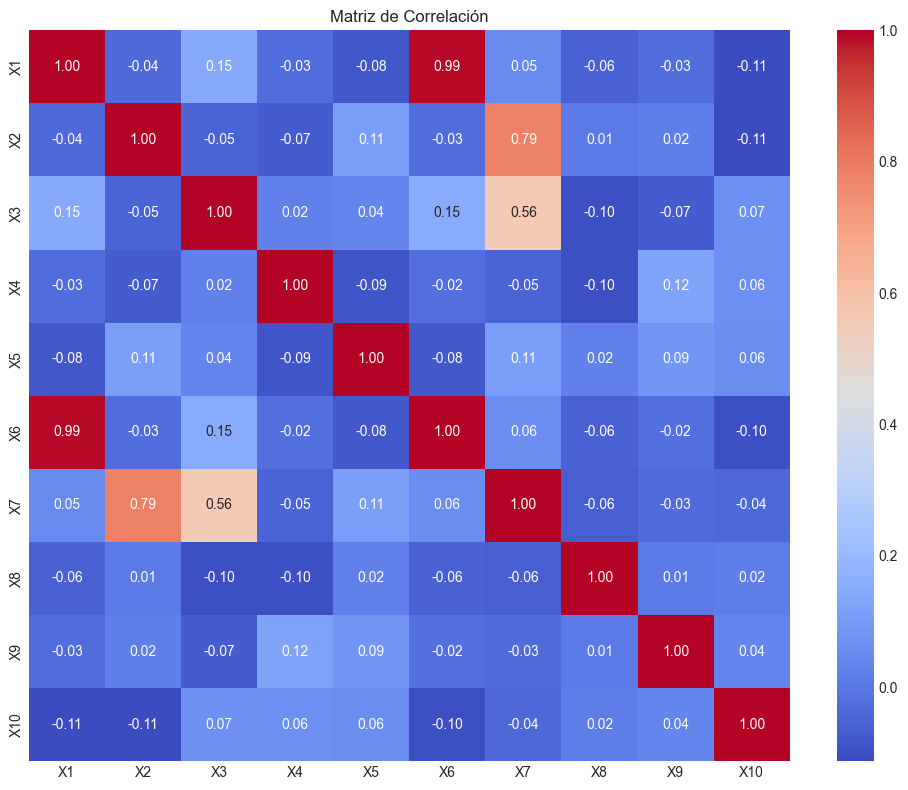

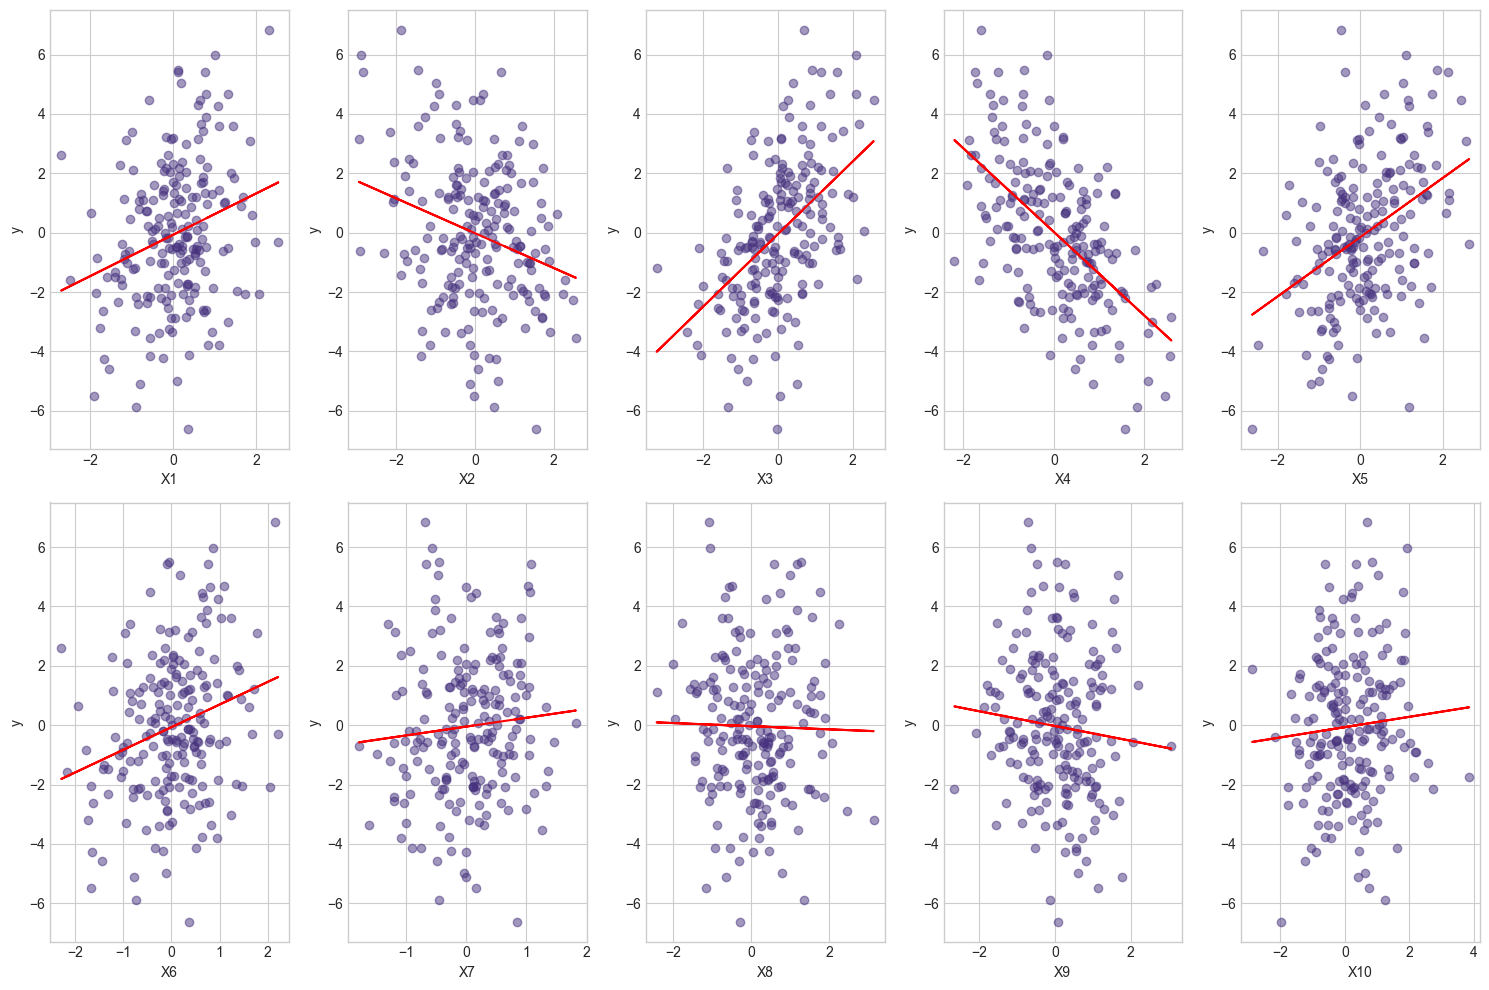


Coeficientes reales:
X1: 0.50
X2: -0.80
X3: 1.20
X4: -1.50
X5: 0.90
X6: 0.00
X7: 0.00
X8: 0.00
X9: 0.00
X10: 0.00

Resumen del modelo completo:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     106.5
Date:                Wed, 02 Apr 2025   Prob (F-statistic):           4.28e-72
Time:                        12:39:33   Log-Likelihood:                -271.91
No. Observations:                 200   AIC:                             565.8
Df Residuals:                     189   BIC:                             602.1
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.02

In [4]:
# Generación de datos simulados

# Fijamos semilla para reproducibilidad
np.random.seed(42)

# Número de observaciones
n = 200

# Número de predictores (5 relevantes, 5 irrelevantes)
p_relevantes = 5
p_irrelevantes = 5
p_total = p_relevantes + p_irrelevantes

# Generamos los predictores
X = np.random.normal(0, 1, size=(n, p_total))
X_df = pd.DataFrame(X, columns=[f'X{i+1}' for i in range(p_total)])

# Generamos la respuesta (solo relacionada con las primeras 5 variables)
beta_real = np.zeros(p_total)
beta_real[:p_relevantes] = [0.5, -0.8, 1.2, -1.5, 0.9]  # Coeficientes para variables relevantes

# Calculamos la respuesta con un término de error
y = X_df.iloc[:, :p_relevantes].values @ beta_real[:p_relevantes] + np.random.normal(0, 1, size=n)

# Añadimos multicolinealidad entre X1 y X6
X_df['X6'] = 0.9 * X_df['X1'] + 0.1 * np.random.normal(0, 1, size=n)

# Añadimos multicolinealidad entre X2, X3 y X7
X_df['X7'] = 0.5 * X_df['X2'] + 0.4 * X_df['X3'] + 0.1 * np.random.normal(0, 1, size=n)

# Mostramos los primeros registros del dataset
print("Primeros 5 registros del dataset simulado:")
print(X_df.head())

# Visualizamos correlaciones
plt.figure(figsize=(10, 8))
sns.heatmap(X_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación')
plt.tight_layout()
plt.show()

# Visualizamos la relación de cada variable con y
plt.figure(figsize=(15, 10))
for i, col in enumerate(X_df.columns):
    plt.subplot(2, 5, i+1)
    plt.scatter(X_df[col], y, alpha=0.5)
    plt.xlabel(col)
    plt.ylabel('y')
    # Añadimos una línea de regresión
    m, b = np.polyfit(X_df[col], y, 1)
    plt.plot(X_df[col], m*X_df[col] + b, color='red')
plt.tight_layout()
plt.show()

# Mostramos los coeficientes reales
print("\nCoeficientes reales:")
for i, b in enumerate(beta_real):
    print(f"X{i+1}: {b:.2f}")

# Ajustamos el modelo completo
X_completo = sm.add_constant(X_df)
modelo_completo = sm.OLS(y, X_completo).fit()

# Mostramos el resumen
print("\nResumen del modelo completo:")
print(modelo_completo.summary())



===== FORWARD SELECTION =====


Forward Selection:   0%|          | 0/10 [00:00<?, ?it/s]

Variables seleccionadas (Forward): ['X4', 'X3', 'X5', 'X2', 'X6', 'X10']

===== BACKWARD ELIMINATION =====


Backward Elimination:   0%|          | 0/10 [00:00<?, ?it/s]

Variables seleccionadas (Backward): ['X2', 'X3', 'X4', 'X5', 'X6', 'X10']

===== STEPWISE SELECTION =====


Stepwise Selection:   0%|          | 0/10 [00:00<?, ?it/s]

Variables seleccionadas (Stepwise): ['X4', 'X3', 'X5', 'X2', 'X6', 'X10']

===== TODOS LOS SUBCONJUNTOS =====


Evaluando subconjuntos:   0%|          | 0/256 [00:00<?, ?it/s]


Mejores 5 modelos según AIC:
                    variables  num_vars       aic        bic    r2_adj  \
198      [X2, X3, X4, X5, X6]         5 -7.801821  11.988084  0.842274   
241  [X2, X3, X4, X5, X6, X8]         6 -6.934152  16.154069  0.842352   
163      [X1, X2, X3, X4, X5]         5 -6.273888  13.516016  0.841065   
240  [X2, X3, X4, X5, X6, X7]         6 -6.194409  16.893813  0.841768   
219  [X1, X2, X3, X4, X5, X6]         6 -6.059778  17.028444  0.841661   

           cp  
198  4.735264  
241  5.647146  
163  6.213336  
240  6.357308  
219  6.486837  


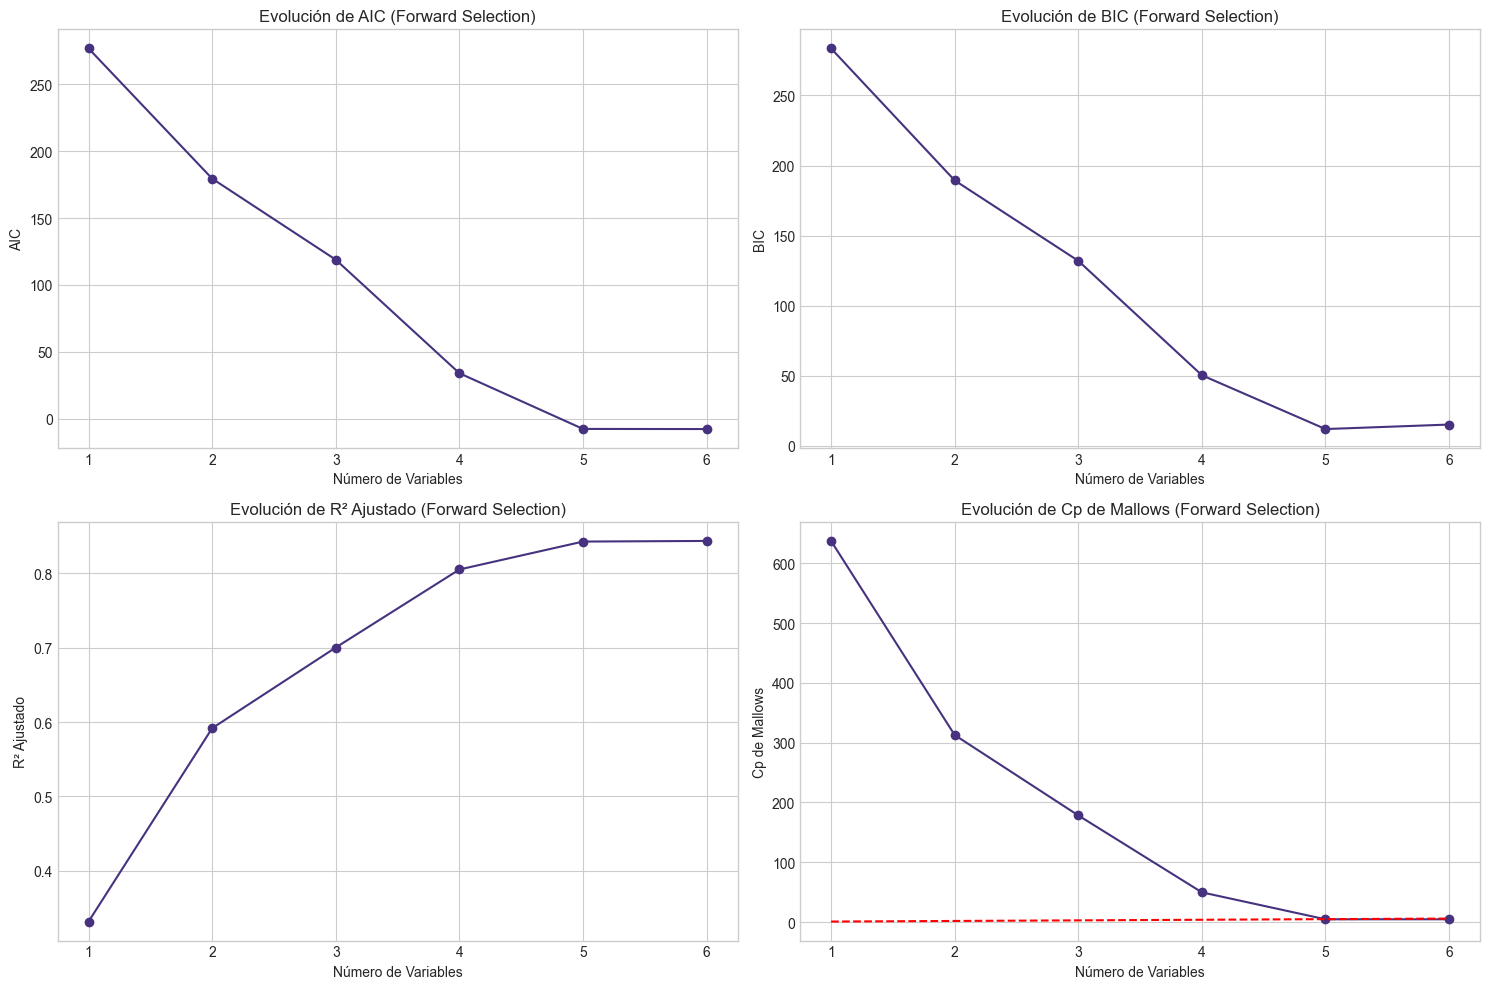


Comparación de Métodos:
         num_vars         aic         bic    r2_adj mse_train
Completo       10  565.813356  602.094847  0.841276  0.887976
Forward         6  559.680796  582.769018  0.843107  0.896306
Backward        6  559.680796  582.769018  0.843107  0.896306
Stepwise        6  559.680796  582.769018  0.843107  0.896306
Real            5  561.301525   581.09143  0.841065   0.91268


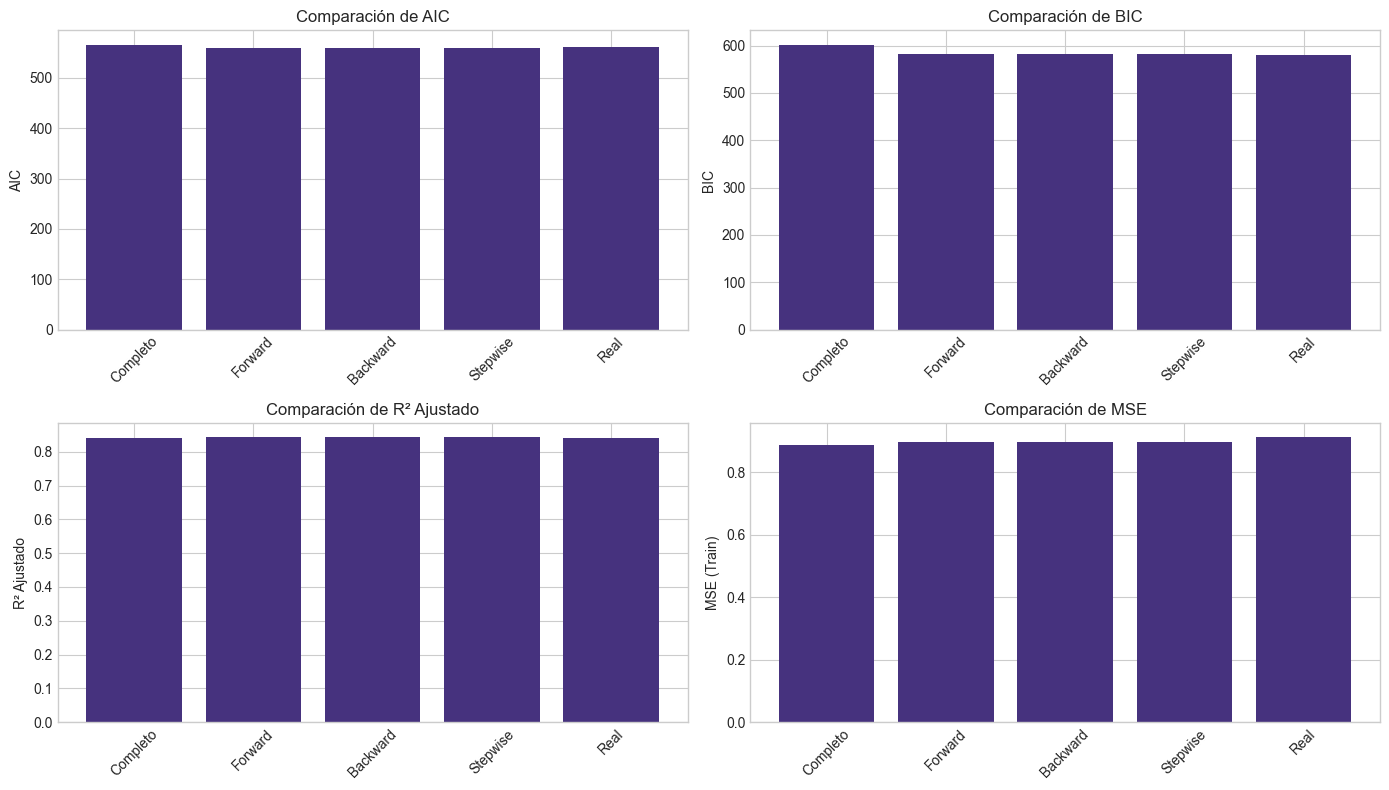

In [5]:
# Aplicación de métodos de selección a los datos simulados

# 1. Forward Selection
print("\n===== FORWARD SELECTION =====")
variables_forward, historial_forward = forward_selection(X_df, y, criterio='aic')
print(f"Variables seleccionadas (Forward): {variables_forward}")

# 2. Backward Elimination
print("\n===== BACKWARD ELIMINATION =====")
variables_backward, historial_backward = backward_elimination(X_df, y, criterio='aic')
print(f"Variables seleccionadas (Backward): {variables_backward}")

# 3. Stepwise Selection
print("\n===== STEPWISE SELECTION =====")
variables_stepwise, historial_stepwise = stepwise_selection(X_df, y, criterio='aic')
print(f"Variables seleccionadas (Stepwise): {variables_stepwise}")

# 4. Todos los subconjuntos (limitado a 8 variables para evitar explosión combinatoria)
print("\n===== TODOS LOS SUBCONJUNTOS =====")
max_vars = 8  # Limitamos para manejar la complejidad computacional
resultados_subconjuntos = todos_subconjuntos(X_df.iloc[:, :max_vars], y, max_vars=max_vars)
print("\nMejores 5 modelos según AIC:")
print(resultados_subconjuntos.head())

# Visualizamos la evolución de los criterios en Forward Selection
plt.figure(figsize=(15, 10))

# AIC
plt.subplot(2, 2, 1)
plt.plot(range(1, len(historial_forward['valores']['aic'])+1), historial_forward['valores']['aic'], marker='o')
plt.xlabel('Número de Variables')
plt.ylabel('AIC')
plt.title('Evolución de AIC (Forward Selection)')
plt.grid(True)

# BIC
plt.subplot(2, 2, 2)
plt.plot(range(1, len(historial_forward['valores']['bic'])+1), historial_forward['valores']['bic'], marker='o')
plt.xlabel('Número de Variables')
plt.ylabel('BIC')
plt.title('Evolución de BIC (Forward Selection)')
plt.grid(True)

# R² Ajustado
plt.subplot(2, 2, 3)
plt.plot(range(1, len(historial_forward['valores']['r2_adj'])+1), historial_forward['valores']['r2_adj'], marker='o')
plt.xlabel('Número de Variables')
plt.ylabel('R² Ajustado')
plt.title('Evolución de R² Ajustado (Forward Selection)')
plt.grid(True)

# Cp de Mallows
if 'cp' in historial_forward['valores'] and historial_forward['valores']['cp'][0] is not None:
    plt.subplot(2, 2, 4)
    plt.plot(range(1, len(historial_forward['valores']['cp'])+1), historial_forward['valores']['cp'], marker='o')
    # Línea de referencia y=x
    plt.plot(range(1, len(historial_forward['valores']['cp'])+1), range(1, len(historial_forward['valores']['cp'])+1), 'r--')
    plt.xlabel('Número de Variables')
    plt.ylabel('Cp de Mallows')
    plt.title('Evolución de Cp de Mallows (Forward Selection)')
    plt.grid(True)

plt.tight_layout()
plt.show()

# Comparamos los diferentes métodos
# Ajustamos modelos con las variables seleccionadas
modelos = {
    'Completo': list(X_df.columns),
    'Forward': variables_forward,
    'Backward': variables_backward,
    'Stepwise': variables_stepwise,
    'Real': [f'X{i+1}' for i in range(p_relevantes)]
}

resultados_comparacion = {}

for nombre, variables in modelos.items():
    if not variables:  # Si no hay variables seleccionadas
        resultados_comparacion[nombre] = {
            'variables': [],
            'num_vars': 0,
            'aic': np.inf,
            'bic': np.inf,
            'r2_adj': -np.inf,
            'mse_train': np.inf
        }
        continue

    # Preparamos los datos
    X_sel = X_df[variables].copy()
    X_sel = sm.add_constant(X_sel)

    # Ajustamos el modelo
    modelo = sm.OLS(y, X_sel).fit()

    # Calculamos métricas
    y_pred = modelo.predict(X_sel)
    mse = mean_squared_error(y, y_pred)

    # Guardamos resultados
    resultados_comparacion[nombre] = {
        'variables': variables,
        'num_vars': len(variables),
        'aic': modelo.aic,
        'bic': modelo.bic,
        'r2_adj': modelo.rsquared_adj,
        'mse_train': mse
    }

# Mostramos la comparación en un DataFrame
comparacion_df = pd.DataFrame(resultados_comparacion).T
print("\nComparación de Métodos:")
print(comparacion_df[['num_vars', 'aic', 'bic', 'r2_adj', 'mse_train']])

# Visualizamos la comparación
plt.figure(figsize=(14, 8))

# AIC
plt.subplot(2, 2, 1)
plt.bar(comparacion_df.index, comparacion_df['aic'])
plt.ylabel('AIC')
plt.title('Comparación de AIC')
plt.xticks(rotation=45)

# BIC
plt.subplot(2, 2, 2)
plt.bar(comparacion_df.index, comparacion_df['bic'])
plt.ylabel('BIC')
plt.title('Comparación de BIC')
plt.xticks(rotation=45)

# R² Ajustado
plt.subplot(2, 2, 3)
plt.bar(comparacion_df.index, comparacion_df['r2_adj'])
plt.ylabel('R² Ajustado')
plt.title('Comparación de R² Ajustado')
plt.xticks(rotation=45)

# MSE
plt.subplot(2, 2, 4)
plt.bar(comparacion_df.index, comparacion_df['mse_train'])
plt.ylabel('MSE (Train)')
plt.title('Comparación de MSE')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


## 5. Estabilidad de la Selección de Variables

Un aspecto importante de la selección de variables es evaluar su estabilidad. Idealmente, un método de selección debería seleccionar las mismas variables incluso con pequeños cambios en los datos.

Utilizaremos bootstrap para evaluar la estabilidad de la selección de variables:
1. Generaremos múltiples muestras bootstrap de nuestros datos
2. Aplicaremos los métodos de selección a cada muestra
3. Calcularemos la frecuencia con la que cada variable es seleccionada



===== ESTABILIDAD MEDIANTE BOOTSTRAP =====

Evaluando estabilidad de Forward Selection...


Evaluando estabilidad:   0%|          | 0/30 [00:00<?, ?it/s]


Evaluando estabilidad de Backward Elimination...


Evaluando estabilidad:   0%|          | 0/30 [00:00<?, ?it/s]


Evaluando estabilidad de Stepwise Selection...


Evaluando estabilidad:   0%|          | 0/30 [00:00<?, ?it/s]

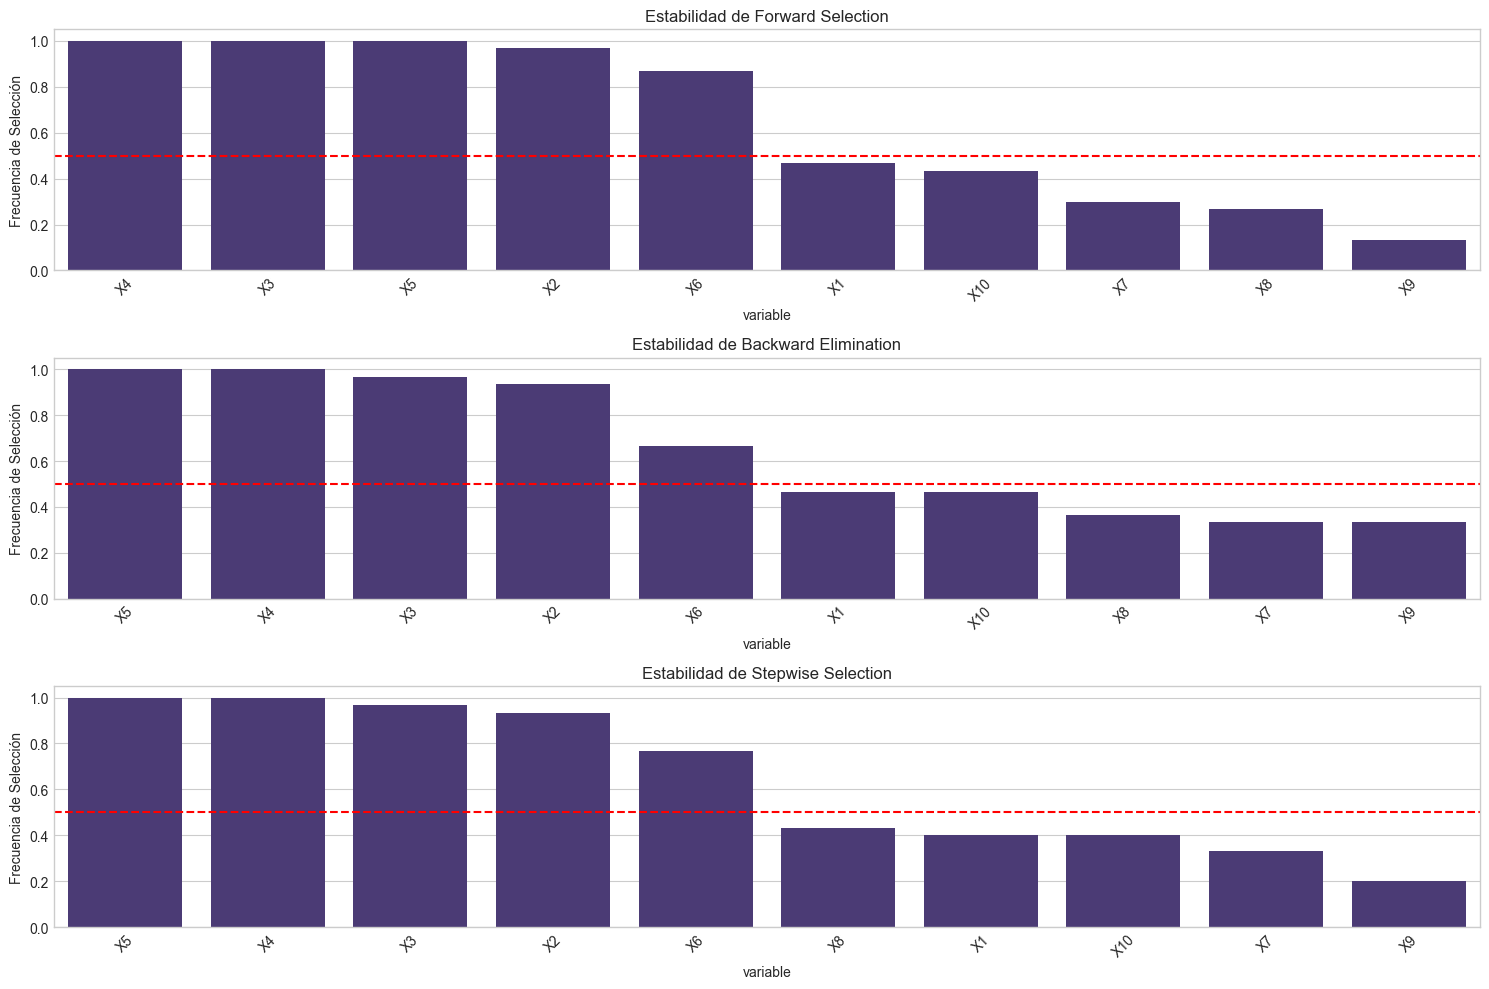


Variables seleccionadas en más del 50% de las muestras bootstrap:

Forward Selection:
  variable  frecuencia
3       X4    1.000000
2       X3    1.000000
4       X5    1.000000
1       X2    0.966667
5       X6    0.866667

Backward Elimination:
  variable  frecuencia
4       X5    1.000000
3       X4    1.000000
2       X3    0.966667
1       X2    0.933333
5       X6    0.666667

Stepwise Selection:
  variable  frecuencia
4       X5    1.000000
3       X4    1.000000
2       X3    0.966667
1       X2    0.933333
5       X6    0.766667

Variables realmente relevantes:
['X1', 'X2', 'X3', 'X4', 'X5']


In [6]:
# Implementación del análisis de estabilidad mediante bootstrap

def evaluar_estabilidad(X, y, metodo, num_bootstrap=100, **kwargs):
    """
    Evalúa la estabilidad de un método de selección de variables mediante bootstrap.

    Parámetros:
    X: DataFrame, predictores
    y: array, variable respuesta
    metodo: función que implementa el método de selección
    num_bootstrap: int, número de repeticiones bootstrap
    **kwargs: argumentos adicionales para el método de selección

    Retorna:
    DataFrame: frecuencias de selección de variables
    """
    todas_columnas = list(X.columns)
    n = len(y)

    # Inicializamos contador de selección
    seleccion_count = {col: 0 for col in todas_columnas}

    # Realizamos bootstrap
    for i in tqdm(range(num_bootstrap), desc=f"Evaluando estabilidad"):
        # Generamos índices bootstrap
        indices = np.random.choice(n, n, replace=True)

        # Creamos muestra bootstrap
        X_boot = X.iloc[indices].reset_index(drop=True)
        y_boot = y[indices]

        # Aplicamos el método de selección
        variables_seleccionadas, _ = metodo(X_boot, y_boot, mostrar_progreso=False, **kwargs)

        # Actualizamos contadores
        for var in variables_seleccionadas:
            seleccion_count[var] += 1

    # Convertimos a frecuencias relativas
    seleccion_freq = {col: count/num_bootstrap for col, count in seleccion_count.items()}

    # Convertimos a DataFrame y ordenamos
    frecuencias_df = pd.DataFrame({
        'variable': list(seleccion_freq.keys()),
        'frecuencia': list(seleccion_freq.values())
    })
    frecuencias_df = frecuencias_df.sort_values('frecuencia', ascending=False)

    return frecuencias_df

# Número de repeticiones bootstrap (reducido para evitar tiempos de ejecución largos)
num_bootstrap = 30

# Evaluamos la estabilidad de cada método
print("\n===== ESTABILIDAD MEDIANTE BOOTSTRAP =====")

print("\nEvaluando estabilidad de Forward Selection...")
estabilidad_forward = evaluar_estabilidad(X_df, y, forward_selection, num_bootstrap=num_bootstrap, criterio='aic')

print("\nEvaluando estabilidad de Backward Elimination...")
estabilidad_backward = evaluar_estabilidad(X_df, y, backward_elimination, num_bootstrap=num_bootstrap, criterio='aic')

print("\nEvaluando estabilidad de Stepwise Selection...")
estabilidad_stepwise = evaluar_estabilidad(X_df, y, stepwise_selection, num_bootstrap=num_bootstrap, criterio='aic')

# Visualizamos los resultados
plt.figure(figsize=(15, 10))

# Forward Selection
plt.subplot(3, 1, 1)
sns.barplot(x='variable', y='frecuencia', data=estabilidad_forward)
plt.title('Estabilidad de Forward Selection')
plt.ylabel('Frecuencia de Selección')
plt.axhline(y=0.5, color='r', linestyle='--')
plt.xticks(rotation=45)

# Backward Elimination
plt.subplot(3, 1, 2)
sns.barplot(x='variable', y='frecuencia', data=estabilidad_backward)
plt.title('Estabilidad de Backward Elimination')
plt.ylabel('Frecuencia de Selección')
plt.axhline(y=0.5, color='r', linestyle='--')
plt.xticks(rotation=45)

# Stepwise Selection
plt.subplot(3, 1, 3)
sns.barplot(x='variable', y='frecuencia', data=estabilidad_stepwise)
plt.title('Estabilidad de Stepwise Selection')
plt.ylabel('Frecuencia de Selección')
plt.axhline(y=0.5, color='r', linestyle='--')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Mostramos las variables más estables (seleccionadas en más del 50% de las muestras)
print("\nVariables seleccionadas en más del 50% de las muestras bootstrap:")
print("\nForward Selection:")
print(estabilidad_forward[estabilidad_forward['frecuencia'] > 0.5])

print("\nBackward Elimination:")
print(estabilidad_backward[estabilidad_backward['frecuencia'] > 0.5])

print("\nStepwise Selection:")
print(estabilidad_stepwise[estabilidad_stepwise['frecuencia'] > 0.5])

# Comparamos con las variables realmente relevantes
print("\nVariables realmente relevantes:")
print([f'X{i+1}' for i in range(p_relevantes)])


## 6. Ejemplo con Datos Reales

Ahora aplicaremos las técnicas de selección de variables a un conjunto de datos reales para predecir el precio de casas.


Dimensiones del dataset: (20640, 8)

Descripción de las variables:
             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000      0.846154      0.333333      3.000000   
25%        2.563400     18.000000      4.440716      1.006079    787.000000   
50%        3.534800     29.000000      5.229129      1.048780   1166.000000   
75%        4.743250     37.000000      6.052381      1.099526   1725.000000   
max       15.000100     52.000000    141.909091     34.066667  35682.000000   

           AveOccup      Latitude     Longitude  
count  20640.000000  20640.000000  20640.000000  
mean       3.070655     35.631861   -119.569704  
std       10.386050      2.135952      2.003532  
min        0.692308  

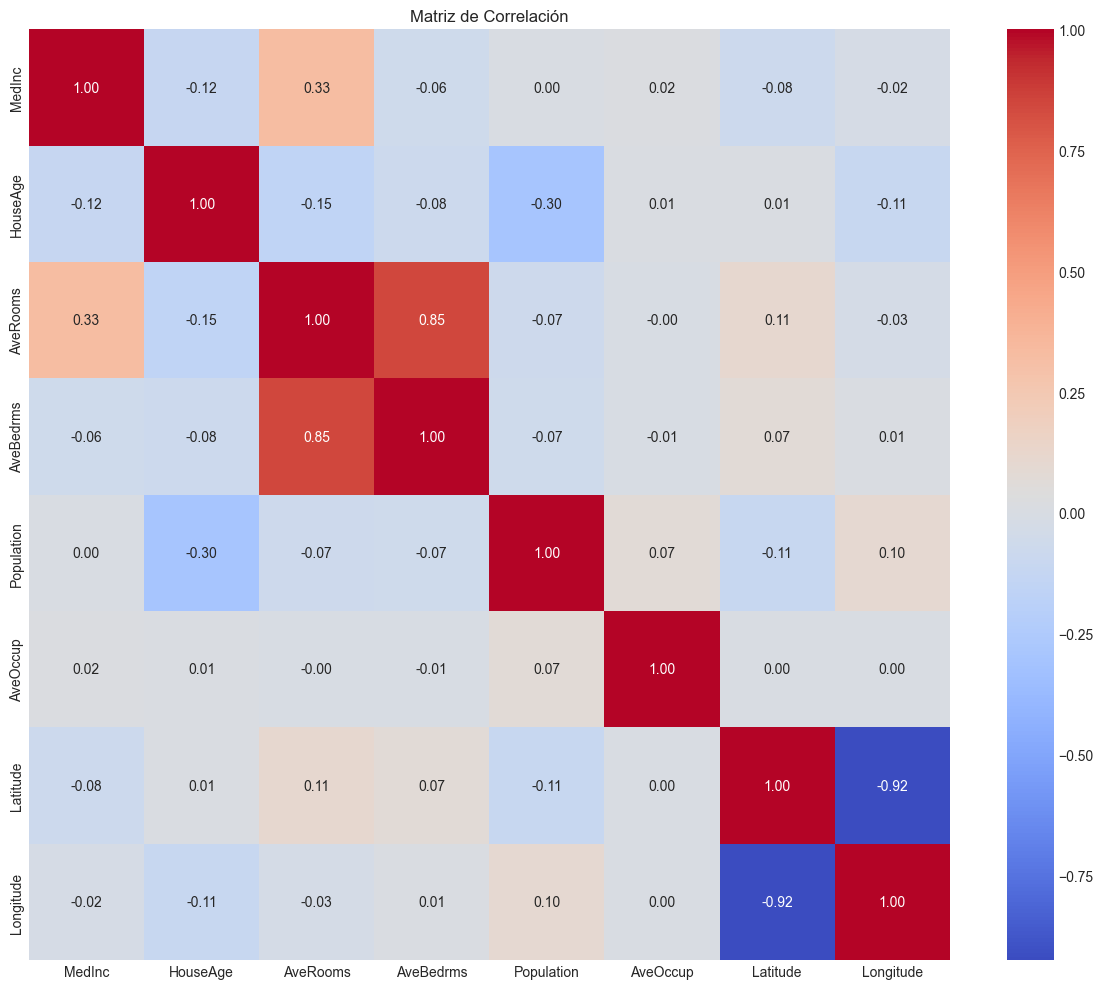


Dimensiones de conjuntos de entrenamiento y prueba:
X_train: (16512, 8), X_test: (4128, 8)

Resumen del modelo completo:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.613
Model:                            OLS   Adj. R-squared:                  0.612
Method:                 Least Squares   F-statistic:                     3261.
Date:                Wed, 02 Apr 2025   Prob (F-statistic):               0.00
Time:                        12:39:39   Log-Likelihood:                -17998.
No. Observations:               16512   AIC:                         3.601e+04
Df Residuals:                   16503   BIC:                         3.608e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------

In [7]:
# Carga de datos para el ejemplo real
# Utilizaremos el dataset de Boston Housing

from sklearn.datasets import fetch_california_housing

# Cargamos el dataset
housing = fetch_california_housing()
X_real = pd.DataFrame(housing.data, columns=housing.feature_names)
y_real = housing.target

print("Dimensiones del dataset:", X_real.shape)
print("\nDescripción de las variables:")
print(X_real.describe())

# Visualizamos correlaciones
plt.figure(figsize=(12, 10))
sns.heatmap(X_real.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación')
plt.tight_layout()
plt.show()

# Dividimos los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_real, y_real, test_size=0.2, random_state=42)
print("\nDimensiones de conjuntos de entrenamiento y prueba:")
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")

# Ajustamos el modelo completo
X_train_const = sm.add_constant(X_train)
modelo_completo_real = sm.OLS(y_train, X_train_const).fit()

# Mostramos el resumen del modelo completo
print("\nResumen del modelo completo:")
print(modelo_completo_real.summary())



===== FORWARD SELECTION =====


Forward Selection:   0%|          | 0/8 [00:00<?, ?it/s]

Variables seleccionadas (Forward): ['MedInc', 'HouseAge', 'Latitude', 'Longitude', 'AveBedrms', 'AveRooms', 'AveOccup']

===== BACKWARD ELIMINATION =====


Backward Elimination:   0%|          | 0/8 [00:00<?, ?it/s]

Variables seleccionadas (Backward): ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'AveOccup', 'Latitude', 'Longitude']

===== STEPWISE SELECTION =====


Stepwise Selection:   0%|          | 0/8 [00:00<?, ?it/s]

Variables seleccionadas (Stepwise): ['MedInc', 'HouseAge', 'Latitude', 'Longitude', 'AveBedrms', 'AveRooms', 'AveOccup']

Comparación de Métodos en Datos Reales:
         num_vars           aic           bic    r2_adj mse_train  mse_test
Completo        8  36013.630296   36083.03688  0.612363  0.517933  0.555892
Forward         7  36011.779907  36073.474648  0.612383  0.517938  0.555953
Backward        7  36011.779907  36073.474648  0.612383  0.517938  0.555953
Stepwise        7  36011.779907  36073.474648  0.612383  0.517938  0.555953


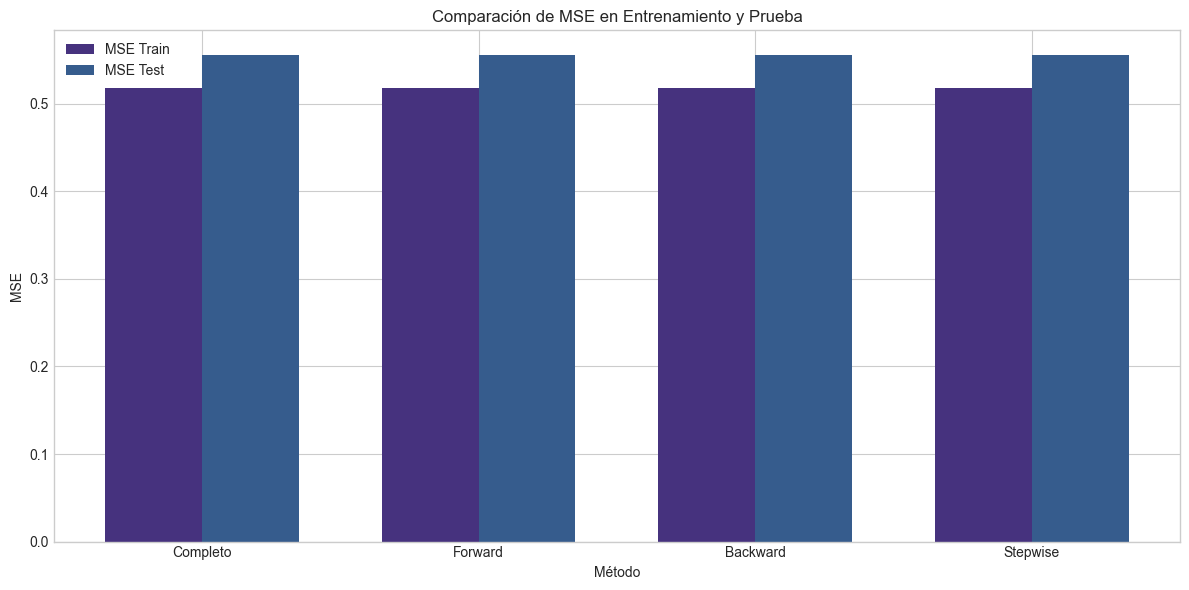

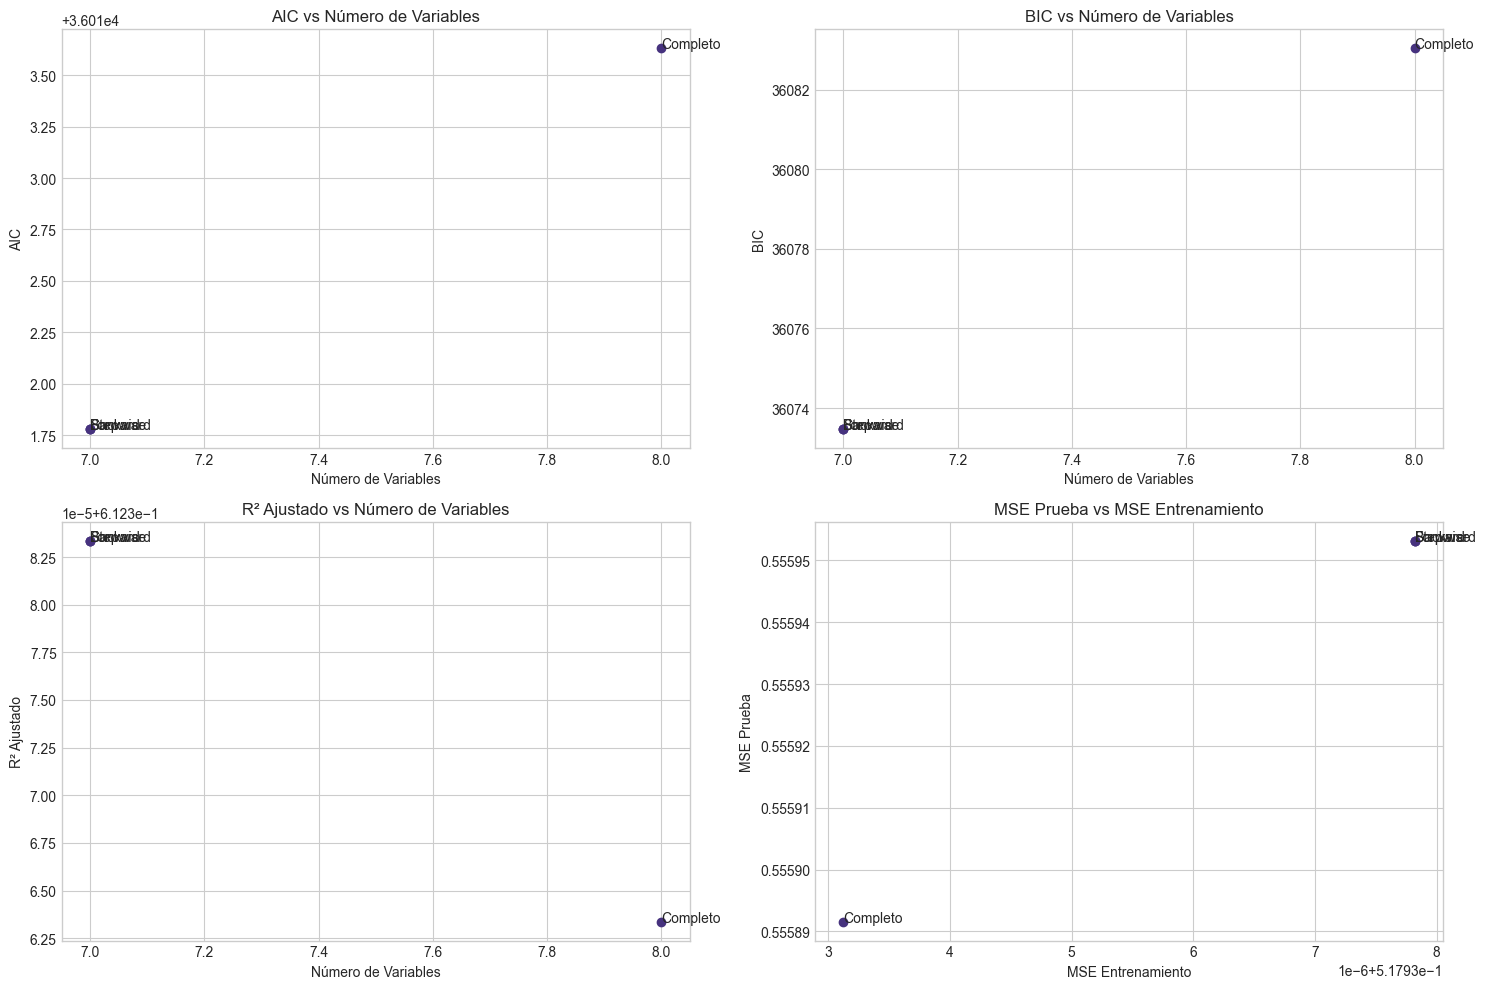

In [8]:
# Aplicación de métodos de selección a datos reales

# 1. Forward Selection
print("\n===== FORWARD SELECTION =====")
variables_forward_real, historial_forward_real = forward_selection(X_train, y_train, criterio='aic')
print(f"Variables seleccionadas (Forward): {variables_forward_real}")

# 2. Backward Elimination
print("\n===== BACKWARD ELIMINATION =====")
variables_backward_real, historial_backward_real = backward_elimination(X_train, y_train, criterio='aic')
print(f"Variables seleccionadas (Backward): {variables_backward_real}")

# 3. Stepwise Selection
print("\n===== STEPWISE SELECTION =====")
variables_stepwise_real, historial_stepwise_real = stepwise_selection(X_train, y_train, criterio='aic')
print(f"Variables seleccionadas (Stepwise): {variables_stepwise_real}")

# Comparamos los diferentes métodos en términos de rendimiento en datos de prueba
modelos_real = {
    'Completo': list(X_train.columns),
    'Forward': variables_forward_real,
    'Backward': variables_backward_real,
    'Stepwise': variables_stepwise_real
}

resultados_comparacion_real = {}

for nombre, variables in modelos_real.items():
    if not variables:  # Si no hay variables seleccionadas
        resultados_comparacion_real[nombre] = {
            'variables': [],
            'num_vars': 0,
            'aic': np.inf,
            'bic': np.inf,
            'r2_adj': -np.inf,
            'mse_train': np.inf,
            'mse_test': np.inf
        }
        continue

    # Preparamos los datos de entrenamiento
    X_train_sel = X_train[variables].copy()
    X_train_sel = sm.add_constant(X_train_sel)

    # Ajustamos el modelo
    modelo = sm.OLS(y_train, X_train_sel).fit()

    # Preparamos los datos de prueba
    X_test_sel = X_test[variables].copy()
    X_test_sel = sm.add_constant(X_test_sel)

    # Calculamos métricas en entrenamiento
    y_train_pred = modelo.predict(X_train_sel)
    mse_train = mean_squared_error(y_train, y_train_pred)

    # Calculamos métricas en prueba
    y_test_pred = modelo.predict(X_test_sel)
    mse_test = mean_squared_error(y_test, y_test_pred)

    # Guardamos resultados
    resultados_comparacion_real[nombre] = {
        'variables': variables,
        'num_vars': len(variables),
        'aic': modelo.aic,
        'bic': modelo.bic,
        'r2_adj': modelo.rsquared_adj,
        'mse_train': mse_train,
        'mse_test': mse_test
    }

# Mostramos la comparación en un DataFrame
comparacion_df_real = pd.DataFrame(resultados_comparacion_real).T
print("\nComparación de Métodos en Datos Reales:")
print(comparacion_df_real[['num_vars', 'aic', 'bic', 'r2_adj', 'mse_train', 'mse_test']])

# Visualizamos la comparación de MSE en entrenamiento y prueba
plt.figure(figsize=(12, 6))

# Barras agrupadas para MSE en entrenamiento y prueba
x = np.arange(len(comparacion_df_real.index))
width = 0.35

plt.bar(x - width/2, comparacion_df_real['mse_train'], width, label='MSE Train')
plt.bar(x + width/2, comparacion_df_real['mse_test'], width, label='MSE Test')

plt.xlabel('Método')
plt.ylabel('MSE')
plt.title('Comparación de MSE en Entrenamiento y Prueba')
plt.xticks(x, comparacion_df_real.index)
plt.legend()
plt.tight_layout()
plt.show()

# Visualizamos la relación entre el número de variables y los criterios
plt.figure(figsize=(15, 10))

# AIC vs Número de Variables
plt.subplot(2, 2, 1)
plt.scatter(comparacion_df_real['num_vars'], comparacion_df_real['aic'])
for i, label in enumerate(comparacion_df_real.index):
    plt.annotate(label, (comparacion_df_real['num_vars'].iloc[i], comparacion_df_real['aic'].iloc[i]))
plt.xlabel('Número de Variables')
plt.ylabel('AIC')
plt.title('AIC vs Número de Variables')
plt.grid(True)

# BIC vs Número de Variables
plt.subplot(2, 2, 2)
plt.scatter(comparacion_df_real['num_vars'], comparacion_df_real['bic'])
for i, label in enumerate(comparacion_df_real.index):
    plt.annotate(label, (comparacion_df_real['num_vars'].iloc[i], comparacion_df_real['bic'].iloc[i]))
plt.xlabel('Número de Variables')
plt.ylabel('BIC')
plt.title('BIC vs Número de Variables')
plt.grid(True)

# R2 Ajustado vs Número de Variables
plt.subplot(2, 2, 3)
plt.scatter(comparacion_df_real['num_vars'], comparacion_df_real['r2_adj'])
for i, label in enumerate(comparacion_df_real.index):
    plt.annotate(label, (comparacion_df_real['num_vars'].iloc[i], comparacion_df_real['r2_adj'].iloc[i]))
plt.xlabel('Número de Variables')
plt.ylabel('R² Ajustado')
plt.title('R² Ajustado vs Número de Variables')
plt.grid(True)

# MSE en Test vs MSE en Entrenamiento
plt.subplot(2, 2, 4)
plt.scatter(comparacion_df_real['mse_train'], comparacion_df_real['mse_test'])
for i, label in enumerate(comparacion_df_real.index):
    plt.annotate(label, (comparacion_df_real['mse_train'].iloc[i], comparacion_df_real['mse_test'].iloc[i]))
plt.xlabel('MSE Entrenamiento')
plt.ylabel('MSE Prueba')
plt.title('MSE Prueba vs MSE Entrenamiento')
plt.grid(True)

plt.tight_layout()
plt.show()


## 7. Conclusiones y Discusión

Después de explorar diferentes métodos de selección de variables, podemos concluir:

1. **Balance entre parsimonia y ajuste**:
   - Los métodos de selección permiten equilibrar la complejidad del modelo y el ajuste a los datos.
   - Criterios como AIC, BIC y R² ajustado proporcionan métricas útiles para esta decisión.

2. **Comparación de métodos**:
   - **Forward Selection**: Enfoque constructivo que puede ser más eficiente computacionalmente pero puede no encontrar el modelo óptimo.
   - **Backward Elimination**: Considera todas las interacciones entre variables pero puede ser más costoso computacionalmente.
   - **Stepwise Selection**: Enfoque híbrido que busca un balance entre eficiencia y exhaustividad.
   - **Todos los Subconjuntos**: El más exhaustivo pero computacionalmente prohibitivo para muchas variables.

3. **Estabilidad**:
   - La selección de variables puede ser inestable con diferentes muestras.
   - El bootstrap revela qué variables son consistentemente seleccionadas.
   - Las variables verdaderamente importantes deberían aparecer con alta frecuencia.

4. **Implicaciones prácticas**:
   - El objetivo no es solo seleccionar variables, sino construir un modelo que:
     - Tenga buen poder predictivo en datos nuevos
     - Sea interpretable
     - Sea estable con diferentes muestras
     - Cumpla con los supuestos del modelo lineal

5. **Limitaciones**:
   - Los métodos stepwise pueden llevar a sobreajuste.
   - Los p-valores resultantes no son exactamente correctos debido al proceso de selección.
   - La multicolinealidad puede afectar qué variables son seleccionadas.

6. **Recomendaciones**:
   - Utilizar validación cruzada para evaluar el rendimiento predictivo.
   - Combinar criterios estadísticos con conocimiento del dominio.
   - Considerar la estabilidad de la selección.
   - Verificar supuestos del modelo lineal después de la selección.
   - Interpretar con cautela los coeficientes después de la selección.


## 8. Conexión con Temas Futuros

La selección de variables está relacionada con varios temas que se explorarán en talleres posteriores:

1. **Validación y Generalización (Taller 11)**:
   - La selección de variables puede llevar a sobreajuste.
   - La validación cruzada es crucial para evaluar la capacidad predictiva real.
   - El bootstrap proporciona información sobre la estabilidad de la selección.

2. **Extensiones No Lineales (Taller 9)**:
   - La selección de variables se puede extender a términos no lineales (interacciones, términos polinómicos).
   - La complejidad aumenta con la inclusión de términos no lineales.

3. **Valores Influyentes y Robustez (Taller 8)**:
   - Los valores atípicos pueden influir en qué variables son seleccionadas.
   - Los métodos robustos pueden proporcionar selecciones más estables.

4. **Análisis de Residuos (Taller 7)**:
   - Después de la selección, es vital verificar los supuestos del modelo.
   - La selección puede afectar la distribución de los residuos.


## 9. Ejercicios

### Ejercicio 1: Implementación y Comparación
Implemente los criterios AIC, BIC y R² ajustado desde cero y compare sus resultados con los proporcionados por statsmodels.

### Ejercicio 2: Selección de Variables con p-valores
Modifique los algoritmos de selección para que utilicen p-valores como criterio de selección en lugar de AIC. Compare los resultados.

### Ejercicio 3: Exploración de Criterios de Parada
Experimente con diferentes criterios de parada para los algoritmos de selección (por ejemplo, umbral de AIC, umbral de p-valor). ¿Cómo afectan a las variables seleccionadas?

### Ejercicio 4: Validación Cruzada
Implemente validación cruzada para evaluar el rendimiento predictivo de los modelos seleccionados. ¿El modelo con mejor AIC/BIC también tiene el mejor rendimiento en validación cruzada?

### Ejercicio 5: Comparación con Regularización
Compare los resultados de la selección de variables con los obtenidos mediante regularización (Ridge, Lasso). ¿Qué enfoque produce mejores resultados predictivos?

### Ejercicio 6: Visualización de Criterios
Cree una visualización que muestre cómo cambian los diferentes criterios (AIC, BIC, R² ajustado, Cp) para todos los posibles subconjuntos de variables en un dataset pequeño.

### Ejercicio 7: Dataset Personalizado
Aplique los métodos de selección a un dataset de su elección. Analice y compare los resultados obtenidos con diferentes métodos.

### Ejercicio 8: Multicolinealidad y Selección
Genere un dataset con multicolinealidad controlada y analice cómo la multicolinealidad afecta a los resultados de la selección de variables.

### Ejercicio 9: Estabilidad con Diferentes Tamaños de Muestra
Analice cómo el tamaño de la muestra afecta la estabilidad de la selección de variables. ¿A partir de qué tamaño muestral se estabiliza la selección?

### Ejercicio 10: Implementación de BIC y Cp de Mallows
Implemente el BIC y el Cp de Mallows desde cero y utilícelos como criterio en los algoritmos de selección. Compare los resultados con los obtenidos utilizando AIC.
